# Chapter 2 - Classifying with Real-World Examples
## The Iris Dataset
## Visualization is a good first step.

In [1]:
import sys
sys.version

'3.9.1 (tags/v3.9.1:1e5d33e, Dec  7 2020, 17:08:21) [MSC v.1927 64 bit (AMD64)]'

In [2]:
from matplotlib import pyplot as plt
import numpy as np

In [3]:
from sklearn.datasets import load_iris
data = load_iris()

In [4]:
features = data.data
feature_names = data.feature_names
target = data.target
target_names = data.target_names
labels = target_names[target]

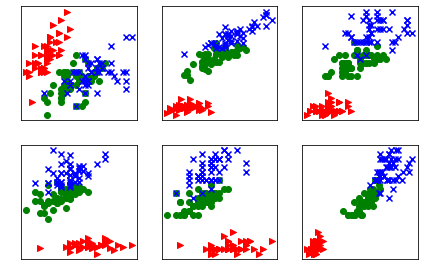

In [5]:
fig,axes = plt.subplots(2, 3)
pairs = [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]

# Set up 3 different pairs of (color, marker)
color_markers = [
        ('r', '>'),
        ('g', 'o'),
        ('b', 'x'),
        ]
for i, (p0, p1) in enumerate(pairs):
    ax = axes.flat[i]

    for t in range(3):
        # Use a different color/marker for each class 't'
        c,marker = color_markers[t]
        ax.scatter(features[target == t, p0], features[target == t, p1], marker=marker, c=c)
    ax.set_xlabel(feature_names[p0], c = 'w')
    ax.set_ylabel(feature_names[p1], c = 'w')
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()

## Building our first classification model
### Using Decision Tree with scikit-learn - Third Edition Book

In [6]:
from sklearn import tree
tr = tree.DecisionTreeClassifier(min_samples_leaf=10)
tr.fit(features, labels)

DecisionTreeClassifier(min_samples_leaf=10)

### Visualizing the tree

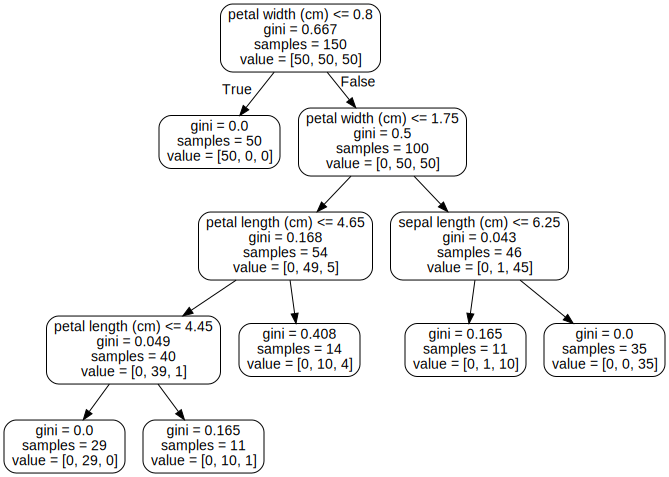

In [7]:
import graphviz
tree.export_graphviz(tr, feature_names=feature_names, rounded=True, out_file='decision.dot')

graphviz.Source(open('decision.dot').read())

In [8]:
prediction = tr.predict(features)
print("Accuracy: {:.1%}".format(np.mean(prediction == labels)))

Accuracy: 96.0%


#### Leave-One-Out Cross-Validation Method

In [9]:
predictions = []
for i in range(len(features)):
    train_features = np.delete(features, i, axis=0)
    train_labels = np.delete(labels, i, axis=0)
    tr.fit(train_features, train_labels)
    predictions.append(tr.predict([features[i]]))
predictions = np.array(predictions)

In [10]:
print("Accuracy (with Leave-One-Out Cross-Validation): {:.1%}".format(np.mean(predictions.ravel() == labels)))

Accuracy (with Leave-One-Out Cross-Validation): 95.3%


#### Five-Fold Cross-Validation with scikit-learn

In [11]:
from sklearn import model_selection
predictions = model_selection.cross_val_predict(
    tr,
    features,
    labels,
    cv=model_selection.LeaveOneOut())
print(np.mean(predictions == labels))

0.9533333333333334


### Using NumPy fancy indexing - Second Edition Book

In [12]:
labels = target_names[target]

In [13]:
# The petal length is the feature at position 2
plength = features[:, 2]

In [14]:
# Build an array of booleans:
is_setosa = (labels == 'setosa')

In [15]:
# This is the important step:
max_setosa =plength[is_setosa].max()
min_non_setosa = plength[~is_setosa].min()
print('Maximum of setosa: {0}.'.format(max_setosa))

Maximum of setosa: 1.9.


In [16]:
print('Minimum of others: {0}.'.format(min_non_setosa))

Minimum of others: 3.0.


In [17]:
# ~ is the boolean negation operator
features = features[~is_setosa]
labels = labels[~is_setosa]
# Build a new target variable, is_virginica
is_virginica = (labels == 'virginica')

### Running a loop over all possible features and thresholds to see which one results in better accuracy.

In [18]:
# Initialize best_acc to impossibly low value
best_acc = -1.0
for fi in range(features.shape[1]):
    # We are going to test all possible thresholds
    thresh = features[:,fi]
    for t in thresh:

        # Get the vector for feature `fi`
        feature_i = features[:, fi]
        # apply threshold `t`
        pred = (feature_i > t)
        acc = (pred == is_virginica).mean()
        rev_acc = (pred == ~is_virginica).mean()
        if rev_acc > acc:
            reverse = True
            acc = rev_acc
        else:
            reverse = False

        if acc > best_acc:
            best_acc = acc
            best_fi = fi
            best_t = t
            best_reverse = reverse

In [19]:
print(best_fi, best_t, best_reverse, best_acc)

3 1.6 False 0.94


In [20]:
def is_virginica_test(fi, t, reverse, example):
    "Apply threshold model to a new example"
    test = example[fi] > t
    if reverse:
        test = not test
    return test

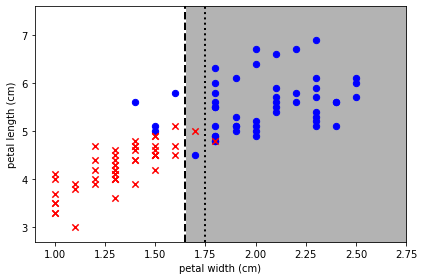

In [21]:
COLOUR_FIGURE = False

# Hand fixed thresholds:
t = 1.65
t2 = 1.75

# Features to use: 3 & 2
f0, f1 = 3, 2

if COLOUR_FIGURE:
    area1c = (1., .8, .8)
    area2c = (.8, .8, 1.)
else:
    area1c = (1., 1, 1)
    area2c = (.7, .7, .7)

# Plot from 90% of smallest value to 110% of largest value
# (all feature values are positive, otherwise this would not work very well)

x0 = features[:, f0].min() * .9
x1 = features[:, f0].max() * 1.1

y0 = features[:, f1].min() * .9
y1 = features[:, f1].max() * 1.1

fig,ax = plt.subplots()
ax.fill_between([t, x1], [y0, y0], [y1, y1], color=area2c)
ax.fill_between([x0, t], [y0, y0], [y1, y1], color=area1c)
ax.plot([t, t], [y0, y1], 'k--', lw=2)
ax.plot([t2, t2], [y0, y1], 'k:', lw=2)
ax.scatter(features[is_virginica, f0],
            features[is_virginica, f1], c='b', marker='o', s=40)
ax.scatter(features[~is_virginica, f0],
            features[~is_virginica, f1], c='r', marker='x', s=40)
ax.set_ylim(y0, y1)
ax.set_xlim(x0, x1)
ax.set_xlabel(feature_names[f0])
ax.set_ylabel(feature_names[f1])
fig.tight_layout()

In [22]:
from threshold import fit_model, accuracy

# Split the data in two: testing and training
testing = np.tile([True, False], 50) # testing = [True,False,True,False,True,False...]

# Training is the negation of testing: i.e., datapoints not used for testing will be used for training
training = ~testing

model = fit_model(features[training], is_virginica[training])
train_accuracy = accuracy(features[training], is_virginica[training], model)
test_accuracy = accuracy(features[testing], is_virginica[testing], model)

print('''\
Training accuracy was {0:.1%}.
Testing accuracy was {1:.1%} (N = {2}).
'''.format(train_accuracy, test_accuracy, testing.sum()))

Training accuracy was 96.0%.
Testing accuracy was 90.0% (N = 50).



#### Leave-One-Out Cross-Validation Method

In [23]:
from threshold import predict

correct = 0.0

for ei in range(len(features)):
    # select all but the one at position `ei`:
    training = np.ones(len(features), bool)
    training[ei] = False
    testing = ~training
    model = fit_model(features[training], is_virginica[training])
    predictions = predict(model, features[testing])
    correct += np.sum(predictions == is_virginica[testing])
acc = correct/float(len(features))
print('Accuracy: {0:.1%}'.format(acc))

Accuracy: 87.0%


## Building more complex classifiers
## A more complex dataset and a more complex classifier
### The Seeds Dataset
### Nearest neighbour classification with scikit-learn

In [24]:
from load import load_dataset

feature_names = [
    'area',
    'perimeter',
    'compactness',
    'length of kernel',
    'width of kernel',
    'asymmetry coefficien',
    'length of kernel groove',
]
data = load_dataset('seeds')
features = data['features']
target = data['target']

In [25]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=1)

In [26]:
kf = model_selection.KFold(n_splits=5, shuffle=False)
# `means` will be a list of mean accuracies (one entry per fold)
means = []
for training,testing in kf.split(features):
   # We learn a model for this fold with `fit` and then apply it to the testing data with `predict`:
   classifier.fit(features[training], target[training])
   prediction = classifier.predict(features[testing])

   # np.mean on an array of booleans returns fraction of correct decisions for this fold:
   curmean = np.mean(prediction == target[testing])
   means.append(curmean)
print('Mean accuracy: {:.1%}'.format(np.mean(means)))

Mean accuracy: 83.8%


### Looking at the decision boundaries

In [27]:
def plot_decision_space(clf, features, target, use_color=True):
    from matplotlib.colors import ListedColormap

    clf.fit(features[:, [0,2]], target)

    y0, y1 = features[:, 2].min() * .9, features[:, 2].max() * 1.1
    x0, x1 = features[:, 0].min() * .9, features[:, 0].max() * 1.1
    X = np.linspace(x0, x1, 1000)
    Y = np.linspace(y0, y1, 1000)
    X, Y = np.meshgrid(X, Y)
    C = clf.predict(np.vstack([X.ravel(), Y.ravel()]).T).reshape(X.shape)
    if use_color:
        cmap = ListedColormap([(1., .7, .7), (.7, 1., .7), (.7, .7, 1.)])
    else:
        cmap = ListedColormap([(1., 1., 1.), (.2, .2, .2), (.6, .6, .6)])

    fig,ax = plt.subplots()
    ax.scatter(features[:, 0], features[:, 2], c=target, cmap=cmap)
    for lab, ma in zip(range(3), "Do^"):
        ax.plot(features[target == lab, 0], features[
                 target == lab, 2], ma, c=(1., 1., 1.), ms=6)

    ax.set_xlim(x0, x1)
    ax.set_ylim(y0, y1)
    ax.set_xlabel(feature_names[0])
    ax.set_ylabel(feature_names[2])
    ax.pcolormesh(X, Y, C, cmap=cmap, shading='auto')
    
    return fig

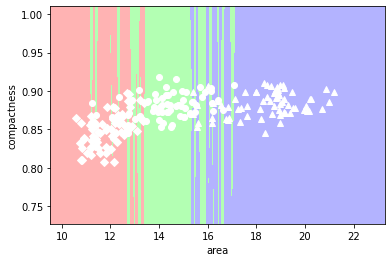

In [28]:
_ = plot_decision_space(classifier, features, target)

### After normalization:

In [29]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

classifier = KNeighborsClassifier(n_neighbors=5)
classifier = Pipeline([('norm', StandardScaler()), ('knn', classifier)])

means = []
for training,testing in kf.split(features):
    classifier.fit(features[training], target[training])
    prediction = classifier.predict(features[testing])

    curmean = np.mean(prediction == target[testing])
    means.append(curmean)
print('Mean accuracy: {:.1%}'.format(np.mean(means)))

Mean accuracy: 86.7%


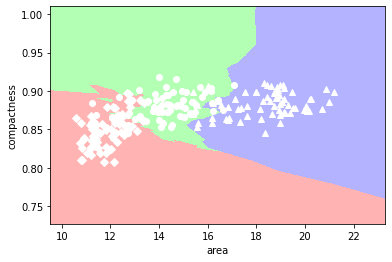

In [30]:
_ = plot_decision_space(classifier, features, target)

## Binary and multiclass classification
### Using random forests classifier

In [36]:
from sklearn import ensemble

rf = ensemble.RandomForestClassifier(n_estimators=100)
predict = model_selection.cross_val_predict(rf, features, target)

print("RF accuracy: {:.1%}".format(np.mean(predict == target)))

RF accuracy: 91.0%


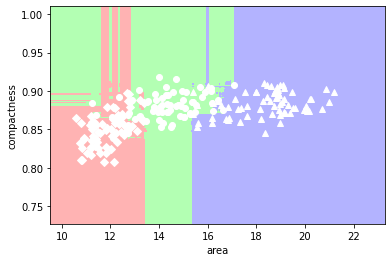

In [37]:
_= plot_decision_space(rf, features, target)